# Testing Module

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import cProfile, pstats
import gc
import pickle

In [19]:
from QLearn.q_agents import HeuristicAgent, QAgent, ReplayMemory
from QLearn.environment import Environment
from QLearn.run_agent import do_run, heuristic_demo, Reward

In [4]:
def t_qnet(agent,env,n_step):
    pr = cProfile.Profile()
    s = env.reset()
    pr.enable()
    for _ in range(n_step):
        a = agent.action_select(s)
        s, r, done, _ = env.step(a)
        agent.update(s,r,done)
    pr.disable()
    sortby = 'cumulative'
    ps = pstats.Stats(pr).sort_stats(sortby)
    return ps

In [17]:
def heuristic(s):
    # Heuristic for:
    # 1. Testing. 
    # 2. Demonstration rollout.
    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center (s[0] is horizontal coordinate, s[2] hor speed)
    if angle_targ >  0.4: angle_targ =  0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proporional to horizontal offset

    # PID controller: s[4] angle, s[5] angularSpeed
    angle_todo = (angle_targ - s[4])*0.5 - (s[5])*1.0
    #print("angle_targ=%0.2f, angle_todo=%0.2f" % (angle_targ, angle_todo))

    # PID controller: s[1] vertical coordinate s[3] vertical speed
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5
    #print("hover_targ=%0.2f, hover_todo=%0.2f" % (hover_targ, hover_todo))

    if s[6] or s[7]: # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    a = 0
    if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
    elif angle_todo < -0.05: a = 3
    elif angle_todo > +0.05: a = 1
    return a

def random_agent(s):
    return np.random.randint(4)

## Run

In [11]:
del agent

In [10]:
import pickle
dat = pickle.load(open('data_test','rb'))

In [ ]:
env = Environment("gym_MarsLander:MarsLander-v0")
gc.enable()
agent = QAgent(env,net_type='MLPQNet',hidden_layers=[80, 40],memory_size=50000,minibatch_size=20,alpha=0.005,clip_norm=1.0,eps0=0.7, n_eps=1500)
R, _, _ = do_run(agent, env, 2000, save_name = 'data_test')
gc.disable()

In [35]:
R_dem = agent_demo(agent,env,5)

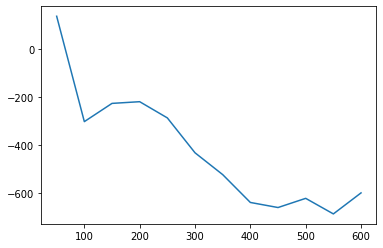

In [34]:
x,R = R.smooth(n_avg=50)
plt.plot(x,R)
plt.show()

In [25]:
env.gym_env.close()

## Compare

In [22]:
env = Environment("gym_MarsLander:MarsLander-v0")
R_heur = heuristic_demo(heuristic, env, 10)

In [23]:
print(R_heur)

[139.91286600739335, 138.4386160788039, 142.84107405675084, 138.82319303007597, 138.50278230497332, 138.1785719777867, 137.18802995522756, 138.58225124555827, 138.05863669572517, 136.44876044597066]


In [32]:
env = Environment("gym_MarsLander:MarsLander-v0")
R_rand = heuristic_demo(random_agent, env, 100)
print(R_rand)
print(np.mean(R_rand))

[-671.2615747059227, -483.13267141688306, -410.15969348230306, -758.4042670664466, -658.8087888707811, -403.37436841514113, -341.2985710054054, -366.55626634328405, -593.5485036150751, -146.11234326611782, -436.81803532045996, -811.5001734807927, -464.5108013046073, -595.2709504567551, -615.6369629466606, -448.31654610810534, -305.42638408137196, -364.96739819484674, -551.4165717205102, -405.6481025490778, -362.6311661207049, -369.737245769936, -335.63678409203334, -528.2138322865976, -443.7885554259294, -382.7384743910433, -512.5288582688576, -362.6175173461205, -352.5471742907337, -384.020367744583, -761.7940999195399, -354.48188772261955, -630.3078624902961, -283.511150870729, -350.036892262617, -377.9574204021787, -411.93830820527313, -528.695833745625, -325.45863681823346, -516.7807322957468, -377.85633704616424, -342.88440713120974, -373.8884150352467, -474.3040456627326, -814.6118771674502, -653.0808471737774, -343.09254277321037, -455.34291015687984, -382.4231527482067, -334.37

## Misc Testing

In [29]:
mem_size = 100000
mem_samp = ReplayMemory(memory_size=mem_size)
for _ in range(mem_size):
    mem_samp.add([np.random.rand(8),np.random.randint(0,4),np.random.rand(),np.random.rand(8),False])

In [31]:
mem_samp[0]

[array([0.37771193, 0.72988155, 0.70613876, 0.80967737, 0.29419905,
        0.14766058, 0.11251306, 0.78238208]),
 3,
 0.39242827380317435,
 array([3.40573134e-04, 8.44221548e-01, 5.73612345e-01, 1.47342524e-01,
        9.09481374e-01, 2.60360363e-01, 2.85117898e-01, 8.57308334e-01]),
 False]

In [27]:
del agent

In [32]:
env = Environment("gym_MarsLander:MarsLander-v0")
agent = QAgent(env,net_type='MLPQNet',hidden_layers=[120, 60],memory_size=100000,minibatch_size=20,alpha=0.005,clip_norm=1.0,eps0=0.7, n_eps=1500)
ps = t_qnet(agent,env,50)
ps.print_stats(20)

         41078 function calls (40176 primitive calls) in 0.555 seconds

   Ordered by: cumulative time
   List reduced from 239 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      105    0.000    0.000    0.533    0.005 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:840(run)
      105    0.003    0.000    0.533    0.005 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1084(_run)
      105    0.001    0.000    0.511    0.005 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1310(_do_run)
      105    0.000    0.000    0.510    0.005 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1354(_do_call)
      105    0.000    0.000    0.510    0.005 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1337(_run_fn)
       74    0.000    0.000    0.372    0.005 /home/call

In [33]:
env = Environment("gym_MarsLander:MarsLander-v0")
agent = QAgent(env,net_type='MLPQNet',hidden_layers=[120, 60],memory_size=100000,minibatch_size=20,alpha=0.005,clip_norm=1.0,eps0=0.7, n_eps=1500)
agent.memory = mem_samp
ps = t_qnet(agent,env,50)
ps.print_stats(20)

         69635 function calls (68085 primitive calls) in 0.930 seconds

   Ordered by: cumulative time
   List reduced from 449 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      161    0.001    0.000    0.891    0.006 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:840(run)
      161    0.004    0.000    0.890    0.006 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1084(_run)
      161    0.001    0.000    0.857    0.005 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1310(_do_run)
      161    0.000    0.000    0.856    0.005 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1354(_do_call)
      161    0.000    0.000    0.855    0.005 /home/callum/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1337(_run_fn)
       50    0.003    0.000    0.658    0.013 /home/call

## Loading Data

In [29]:
fname = 'data1_14_2.pkl'
data = pickle.load(open(fname,'rb'))

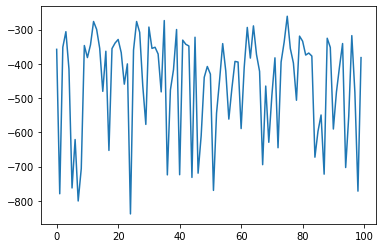

In [31]:
plt.plot(R_rand)
plt.show()

-342.8018542017342


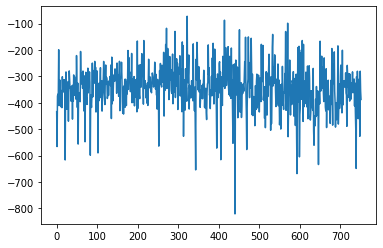

In [30]:
print(np.mean(data['R']))
plt.plot(data['R'])
plt.show()

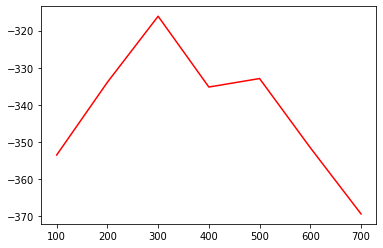

In [13]:
x,R_ep = data['R'].smooth()
plt.plot(x,R_ep,'r')
plt.show()